# Install Library

In [2]:

!uv pip install torch
!uv pip install torchvision
!uv pip install numpy
!uv pip install matplotlib
!uv pip install scikit-learn

Resolved 25 packages in 72ms                                         
Installed 21 packages in 265ms                              
 + filelock==3.19.1
 + fsspec==2025.9.0
 + mpmath==1.3.0
 + networkx==3.5
 + nvidia-cublas-cu12==12.8.4.1
 + nvidia-cuda-cupti-cu12==12.8.90
 + nvidia-cuda-nvrtc-cu12==12.8.93
 + nvidia-cuda-runtime-cu12==12.8.90
 + nvidia-cudnn-cu12==9.10.2.21
 + nvidia-cufft-cu12==11.3.3.83
 + nvidia-cufile-cu12==1.13.1.3
 + nvidia-curand-cu12==10.3.9.90
 + nvidia-cusolver-cu12==11.7.3.90
 + nvidia-cusparse-cu12==12.5.8.93
 + nvidia-cusparselt-cu12==0.7.1
 + nvidia-nccl-cu12==2.27.3
 + nvidia-nvjitlink-cu12==12.8.93
 + nvidia-nvtx-cu12==12.8.90
 + sympy==1.14.0
 + torch==2.8.0
 + triton==3.4.0
Resolved 28 packages in 96ms                                         
Prepared 1 package in 239ms                                              
Installed 3 packages in 10ms                                
 + numpy==2.3.3
 + pillow==11.3.0
 + torchvision==0.23.0
Audited 1 package in 

# Set Dataset & Dataloader

In [30]:

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [31]:
BATCH_SIZE = 32

In [32]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

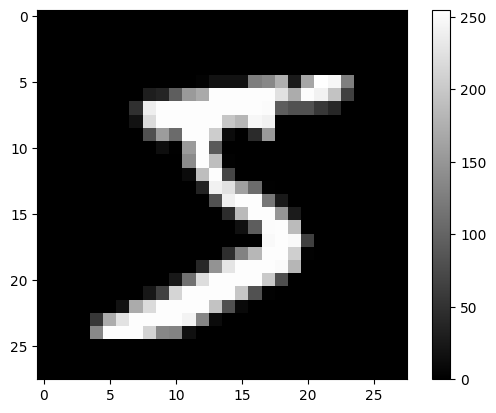

In [33]:
plt.imshow(train_DS.data[0], cmap='gray')
plt.colorbar()

In [34]:
from torch.utils.data import DataLoader

In [35]:
train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
x_batch, y_batch = next(iter(train_DL))

In [37]:
x_batch.shape

torch.Size([32, 1, 28, 28])

# Set Model

In [86]:
import torch
from torch import nn

In [87]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


In [88]:
class Flatten(nn.Module):
    def forward(self, x):
        batch = x.shape[0]
        return x.reshape(batch, -1)


class DeFlatten(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.k = x

    def forward(self, x):
        batch = x.shape[0]
        # x.shape[1] = self.k * w^2
        # x.shape[1] // self.k ** 0.5 = w
        width = int((x.shape[1] // self.k) ** 0.5)
        return x.reshape(batch, self.k, width, width)


## AutoEncoder

In [89]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        k = 16
        self.encoder = nn.Sequential(
            Flatten(),
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=20),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            # nn.Linear(in_features=2, out_features=512),
            # nn.ReLU(),
            nn.Linear(in_features=20, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=28 * 28),
            nn.Sigmoid(),
            DeFlatten(1)
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode, encode

## ConvAutoEncoder

In [90]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        k = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=k, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=k, out_channels=k * 2, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=k * 2, out_channels=k * 4, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=1024, out_features=20),
            nn.ReLU(),
            # nn.Linear(in_features=512, out_features=2),
            # nn.ReLU()
        )

        self.decoder = nn.Sequential(
            # nn.Linear(in_features=2, out_features=512),
            # nn.ReLU(),
            nn.Linear(in_features=20, out_features=1024),
            nn.ReLU(),
            DeFlatten(k * 4),
            nn.ConvTranspose2d(in_channels=k * 4, out_channels=k * 2, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=k * 2, out_channels=k, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=k, out_channels=1, kernel_size=3, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode, encode

## VariationalAutoEncoder

In [107]:
class VariAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Flatten(),
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.aver = nn.Linear(128, 20)
        self.vari = nn.Linear(128, 20)
        self.decoder = nn.Sequential(
            nn.Linear(in_features=20, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=28 * 28),
            nn.Sigmoid(),
            DeFlatten(1)
        )

    def reparameterize(self, aver, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return aver + eps * std

    def forward(self, x):
        h = self.encoder(x)
        aver = self.aver(h)
        log_var = self.vari(h)
        z = self.reparameterize(aver, log_var)

        decode = self.decoder(z)
        return decode, aver, log_var

# Train Model

In [45]:
from torch import optim

In [46]:
def normalize_output(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img


def check_plot(model):
    with torch.no_grad():
        for data in train_DL:
            inputs = data[0].to(DEVICE)
            outputs = model(inputs)

            input_samples = inputs.permute(0, 2, 3, 1).cpu().numpy()  # 원래 이미지
            reconstructed_samples = outputs.permute(0, 2, 3, 1).cpu().numpy()  # 생성 이미지
            break  # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 8  # 시각화 전체 너비
    rows = 4  # 시각화 전체 높이

    fig = plt.figure(figsize=(columns, rows))  # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns * rows + 1):
        img = input_samples[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig = plt.figure(figsize=(columns, rows))

    for i in range(1, columns * rows + 1):
        img = reconstructed_samples[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [47]:
def cluster_dist(enc, centers):
    expanded_enc = enc.unsqueeze(1)  # (batch, 1, 10)
    expanded_cen = centers.unsqueeze(0)  # (1, 10, 10)
    distance = torch.sum((expanded_enc - expanded_cen) ** 2, dim=2)
    min_dist, _ = torch.min(distance, dim=1)
    return torch.mean(min_dist)

In [100]:
def vae_loss_function(y, x, aver, log_var):
    BCE = nn.functional.binary_cross_entropy(y.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')
    KL = -0.5 * torch.sum(1 + log_var - aver.pow(2) - log_var.exp())
    return BCE + KL

In [58]:
def train(model: nn.Module, criterion, optimizer, epoch, model_type='normal'):
    losses = []
    for e in range(epoch):
        epoch_loss = 0.0
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            optimizer.zero_grad()


            if model_type == 'VAE':
                x_hat, mu, log_var = model(x_batch)
                loss = criterion(x_hat, x_batch, mu, log_var)
            else:
                x_hat, enc = model(x_batch)
                loss = criterion(x_hat, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        cost = epoch_loss / len(train_DL)
        print(f'Epoch {e}: {cost:.4f}')
        losses.append(epoch_loss)

In [ ]:
ae = AutoEncoder().to(DEVICE)
epoch = 31
criterion = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(ae.parameters(), lr=1e-4)

train(ae, criterion, optimizer, epoch)
save_model_path = './results/autoencoder.pt'
torch.save(ae.state_dict(), save_model_path)

In [108]:
vae = VariAutoEncoder().to(DEVICE)
epoch = 31
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

train(vae, vae_loss_function, optimizer, epoch, model_type='VAE')
save_model_path = './results/variautoencoder.pt'
torch.save(vae.state_dict(), save_model_path)

Epoch 0: 5762.4393
Epoch 1: 4967.9583
Epoch 2: 4739.6509
Epoch 3: 4645.3808
Epoch 4: 4582.2603
Epoch 5: 4543.5672
Epoch 6: 4509.2487
Epoch 7: 4491.7834
Epoch 8: 4461.7854
Epoch 9: 4444.2650
Epoch 10: 4433.9026
Epoch 11: 4423.2565
Epoch 12: 4411.0714
Epoch 13: 4404.6958
Epoch 14: 4392.2658
Epoch 15: 4382.0066
Epoch 16: 4378.7479
Epoch 17: 4373.8824
Epoch 18: 4373.1530
Epoch 19: 4366.6970
Epoch 20: 4362.7426
Epoch 21: 4355.2430
Epoch 22: 4347.3557
Epoch 23: 4350.1801
Epoch 24: 4347.2222
Epoch 25: 4344.9625
Epoch 26: 4352.3044
Epoch 27: 4341.8911
Epoch 28: 4340.2998
Epoch 29: 4338.0297
Epoch 30: 4333.9319


# Clustering

## K-Means

In [ ]:
autoencoder = AutoEncoder().to(DEVICE)
autoencoder.load_state_dict(torch.load('results/autoencoder.pt', map_location=DEVICE))

In [ ]:
from sklearn.cluster import KMeans

autoencoder.eval()
all_encoded_vectors = []
with torch.no_grad():
    for x_batch, _ in train_DL:
        x_batch = x_batch.to(DEVICE)

        _, encode = autoencoder(x_batch)
        all_encoded_vectors.append(encode.to('cpu'))
all_encoded_vectors = torch.cat(all_encoded_vectors).numpy()

In [19]:
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
kmeans.fit(all_encoded_vectors)
cluster_centers = torch.from_numpy(kmeans.cluster_centers_).float().to(DEVICE)

# Test Model

In [87]:
criterion = nn.MSELoss()


def test(model):
    with torch.no_grad():
        t_loss = 0.0
        for x_batch, _ in test_DL:
            x_batch = x_batch.to(DEVICE)
            x_hat, _ = model(x_batch)

            loss = criterion(x_hat, x_batch)
            t_loss += loss
        t_loss /= len(test_DL)
    print(t_loss)

In [88]:
test(autoencoder)

tensor(0.0087, device='cuda:0')


In [89]:
from sklearn.manifold import TSNE

In [90]:
autoencoder.eval()
test_latent_vectors = []
test_labels = []
with torch.no_grad():
    for data, labels in test_DL:
        img = data.to(DEVICE)
        _, latent = autoencoder(img)
        test_latent_vectors.append(latent.cpu())
        test_labels.append(labels)
test_latent_vectors = torch.cat(test_latent_vectors).numpy()
test_labels = torch.cat(test_labels).numpy()

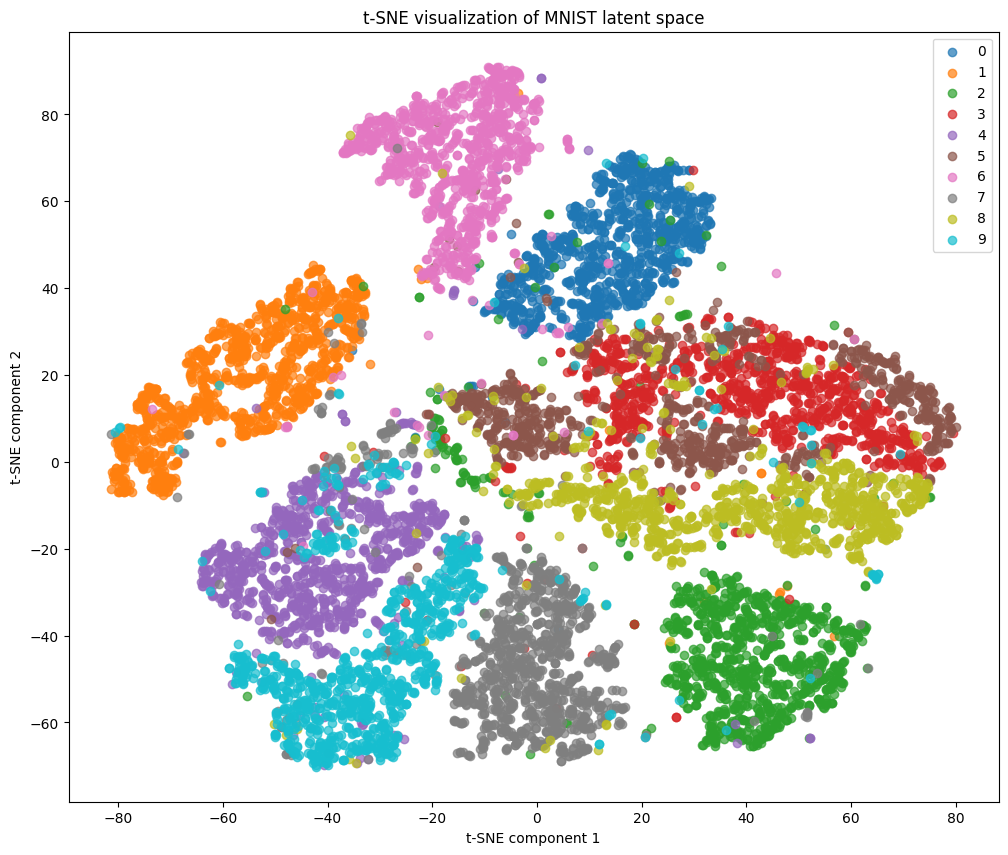

In [91]:
# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_tsne = tsne.fit_transform(test_latent_vectors)

# 시각화
plt.figure(figsize=(12, 10))
for i in range(10):
    indices = test_labels == i
    plt.scatter(latent_tsne[indices, 0], latent_tsne[indices, 1], label=str(i), alpha=0.7)
plt.legend()
plt.title("t-SNE visualization of MNIST latent space")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

In [92]:
from sklearn.metrics import adjusted_rand_score

In [93]:
test_pred = kmeans.predict(test_latent_vectors)

In [94]:
adjusted_rand_score(test_labels, test_pred)

0.25815210778109804

In [95]:
from scipy.stats import mode

In [96]:
for i in range(10):
    get_label = mode(test_labels[test_pred == i])[0]
    print(get_label)

8
5
0
4
7
9
6
3
1
2



--- Generating new images with VAE ---


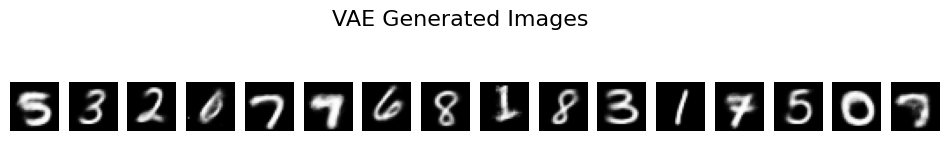

In [106]:
def generate_images_from_vae(model, num_images=16):
    model.eval()
    with torch.no_grad():
        # 잠재 공간에서 표준 정규분포를 따르는 벡터를 무작위로 샘플링합니다.
        z = torch.randn(num_images, 20).to(DEVICE)
        # 디코더를 통해 샘플링된 잠재 벡터로부터 새로운 이미지를 생성합니다.
        generated = model.decoder(z).cpu()

        fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
        fig.suptitle("VAE Generated Images", fontsize=16)
        for i in range(num_images):
            axes[i].imshow(generated[i].view(28, 28), cmap='gray')
            axes[i].axis('off')
        plt.show()

print("\n--- Generating new images with VAE ---")
generate_images_from_vae(vae)